# Reload the data, create the adv for G_11, Test for all model

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import keras
import numpy as np
import os
from six.moves import xrange

import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval, batch_eval

from cleverhans.attacks import fgsm
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes, cnn_model, pair_visual, grid_visual
from Gnet import G_10,G_11,G_12,G_13


Using TensorFlow backend.


In [2]:
FLAGS = flags.FLAGS
flags.DEFINE_integer('nb_epochs', 6, 'Number of epochs to train model')
flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
flags.DEFINE_float('learning_rate', 0.1, 'Learning rate for training')

In [3]:
import tensorflow as tf
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

###########################################################################
# Define the dataset and model
###########################################################################

# Image dimensions ordering should follow the Theano convention
if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' "
          "to 'th', temporarily setting to 'tf'")

# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)
print("Created TensorFlow session and set Keras backend.")

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist()
print("Loaded MNIST test data.")

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

Created TensorFlow session and set Keras backend.
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Loaded MNIST test data.


In [4]:
###########################################################################
# restore G_11_adv_trained model
###########################################################################
# save_path = os.path.join(FLAGS.train_dir, FLAGS.filename)
# Define TF model graph
model = G_11()
predictions_1_adv = model(x)

print("Defined TensorFlow model graph.")
saver = tf.train.Saver()

save_path = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G11_adv/G11_advmodel'
#save_path3 = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
saver.restore(sess, save_path)


Defined TensorFlow model graph.
INFO:tensorflow:Restoring parameters from /home/boyuan/Documents/research/Advesarial_examples/Project/store/G11_adv/G11_advmodel


In [4]:
###########################################################################
# restore G_11 model
###########################################################################
# save_path = os.path.join(FLAGS.train_dir, FLAGS.filename)
# Define TF model graph
model = G_11()
predictions_1 = model(x)

print("Defined TensorFlow model graph.")
saver = tf.train.Saver()

save_path = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G11/G11model'
#save_path3 = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
saver.restore(sess, save_path)


Defined TensorFlow model graph.
INFO:tensorflow:Restoring parameters from /home/boyuan/Documents/research/Advesarial_examples/Project/store/G11/G11model


In [4]:
###########################################################################
# restore G_10 model
###########################################################################
# Define TF model graph
model_0 = G_10()
predictions_0 = model_0(x)

print("Defined TensorFlow model graph.")
saver = tf.train.Saver()

save_path = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
#save_path3 = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
saver.restore(sess, save_path)

Defined TensorFlow model graph.
INFO:tensorflow:Restoring parameters from /home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model


In [4]:
###########################################################################
# restore G_12 model
###########################################################################
# Define TF model graph
model_2 = G_12()
predictions_2 = model_2(x)

print("Defined TensorFlow model graph.")
saver = tf.train.Saver()

save_path = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G12/G12model'
#save_path3 = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
saver.restore(sess, save_path)

Defined TensorFlow model graph.
INFO:tensorflow:Restoring parameters from /home/boyuan/Documents/research/Advesarial_examples/Project/store/G12/G12model


In [4]:
###########################################################################
# restore G_13 model
###########################################################################
# Define TF model graph
model_3 = G_13()
predictions_3 = model_3(x)

print("Defined TensorFlow model graph.")
saver = tf.train.Saver()

save_path = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G13/G13model'
#save_path3 = '/home/boyuan/Documents/research/Advesarial_examples/Project/store/G10/G10model'
saver.restore(sess, save_path)

Defined TensorFlow model graph.
INFO:tensorflow:Restoring parameters from /home/boyuan/Documents/research/Advesarial_examples/Project/store/G13/G13model


## creating the adversarial examples

### 1.create the adv from G_11 net

In [8]:
# Craft adversarial examples using Fast Gradient Sign Method (FGSM)
adv_x = fgsm(x, predictions_1, eps=0.3)
eval_params = {'batch_size': FLAGS.batch_size}
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test], args=eval_params)
assert X_test_adv.shape[0] == 10000, X_test_adv.shape

In [9]:
X_test_adv.shape
adv_diff = X_test_adv - X_test
# calculate the disturbation
adv_diff.shape

(10000, 28, 28, 1)

In [10]:
# test the accuracy with G_11
accuracy = model_eval(sess, x, y, predictions_1, X_test_adv, Y_test,
                          args=eval_params)
print(accuracy)

0.0451


### 2.pack the adv_G11 for testing all the networks

In [11]:
from six.moves import cPickle as pickle
pickle_file = 'adv_G11.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'adv_dataset': X_test_adv,
        'test_labels': Y_test,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

## Reload the file for other model

### 1. reload from pickle

In [10]:
from six.moves import cPickle as pickle
pickle_file = 'adv_G11.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    adv_dataset = save['adv_dataset']
    adv_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Test set', adv_dataset.shape, adv_labels.shape)

Test set (10000, 28, 28, 1) (10000, 10)


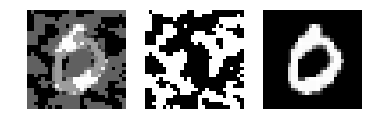

In [13]:
# demon a advesarial example
img_rows = 28
img_cols = 28;
figure = pair_visual(np.reshape(adv_dataset[3],
                                (img_rows, img_cols)),
                     np.reshape(X_test[3],(img_rows, img_cols)))

## Test the accuracy for each datasets

In [6]:
eval_params = {'batch_size': FLAGS.batch_size}

In [7]:
# test the accuracy with G_11_adv training model
accuracy_1_adv = model_eval(sess, x, y, predictions_1_adv, adv_dataset, adv_labels,
                          args=eval_params)
print(accuracy_1_adv)

0.1134


In [10]:
# test the accuracy with G_10
accuracy_0 = model_eval(sess, x, y, predictions_0, adv_dataset, adv_labels,
                          args=eval_params)
print(accuracy_0)

0.1509


In [7]:
# test the accuracy with G_11
accuracy_1 = model_eval(sess, x, y, predictions_1, adv_dataset, adv_labels,
                          args=eval_params)
print(accuracy_1)

0.0451


In [8]:
# test the accuracy with G_12
accuracy_2 = model_eval(sess, x, y, predictions_2, adv_dataset, adv_labels,
                          args=eval_params)
print(accuracy_2)

0.0796


In [9]:
# test the accuracy with G_13
accuracy_3 = model_eval(sess, x, y, predictions_3, adv_dataset, adv_labels,
                          args=eval_params)
print(accuracy_3)

0.1569


## looking at a specific example

In [6]:
def model_eval_single(sess, x, y, model, X_test, args=None):
    """
    Compute the accuracy of a TF model on some data
    :param sess: TF session to use when training the graph
    :param x: input placeholder
    :param y: output placeholder (for labels)
    :param model: model output predictions
    :param X_test: numpy array with training inputs
    :param Y_test: numpy array with training outputs
    :param args: dict or argparse `Namespace` object.
                 Should contain `batch_size`
    :return: a float with the accuracy value
    """

    # Define symbol for accuracy
    # Keras 2.0 categorical_accuracy no longer calculates the mean internally
    # tf.reduce_mean is called in here and is backward compatible with previous
    # versions of Keras
    acc_value = model


    with sess.as_default():
        cur_acc = acc_value.eval(
            feed_dict={x: X_test,
                       keras.backend.learning_phase(): 0})


        # Divide by number of examples to get final value
        accuracy = cur_acc

    return accuracy

In [8]:
# Test with G_10
accuracy = model_eval_single(sess, x, y, predictions_0, adv_dataset[3:4], Y_test)
accuracy2 = model_eval_single(sess, x, y, predictions_0, X_test[3:4], Y_test)
accuracy3 = model_eval_single(sess, x, y, predictions_0, X_test[3:4]-adv_dataset[3:4], Y_test)
print(accuracy)
print(accuracy2)
print(accuracy3)
print('the prediction probability for adv_dataset the most likely label is:',np.argmax(accuracy))
print(accuracy2[0][np.argmax(accuracy)]*100)
print('the prediction probability for test_dataset the most likely label is:',np.argmax(accuracy2))
print(accuracy2[0][np.argmax(accuracy2)]*100)
print('the prediction probability for perturbation the most likely label is:',np.argmax(accuracy3))
print(accuracy2[0][np.argmax(accuracy3)]*100)
print('the real label is:', np.argmax(Y_test[3]))

[[ 0.12515967  0.09121243  0.06959603  0.07286353  0.04800599  0.10128239
   0.2864027   0.11342938  0.03099665  0.06105119]]
[[ 0.92608136  0.00709069  0.01035078  0.00435896  0.006283    0.00825908
   0.01454419  0.01002554  0.00480614  0.00820024]]
[[ 0.19721605  0.0807325   0.0788397   0.07590845  0.09110018  0.12106974
   0.08015344  0.12976149  0.07655197  0.06866659]]
the prediction probability for adv_dataset the most likely label is: 6
1.45441908389
the prediction probability for test_dataset the most likely label is: 0
92.6081359386
the prediction probability for perturbation the most likely label is: 0
92.6081359386
the real label is: 0


In [11]:
# Test with G_11
accuracy = model_eval_single(sess, x, y, predictions_1, adv_dataset[3:4], Y_test)
accuracy2 = model_eval_single(sess, x, y, predictions_1, X_test[3:4], Y_test)
accuracy3 = model_eval_single(sess, x, y, predictions_1, X_test[3:4]-adv_dataset[3:4], Y_test)
print(accuracy)
print(accuracy2)
print(accuracy3)
print('the prediction probability for adv_dataset the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)
print('the prediction probability for test_dataset the most likely label is:',np.argmax(accuracy2))
print(accuracy2[0][np.argmax(accuracy2)]*100)
print('the prediction probability for perturbation the most likely label is:',np.argmax(accuracy3))
print(accuracy3[0][np.argmax(accuracy3)]*100)
print('the real label is:', np.argmax(Y_test[3]))

[[ 0.09220058  0.08569479  0.0660625   0.12602471  0.05674984  0.13069081
   0.22989927  0.11420287  0.03363661  0.06483797]]
[[ 0.92498761  0.00880429  0.00600167  0.00411614  0.00751133  0.01012791
   0.01449203  0.01081352  0.00498748  0.00815813]]
[[ 0.2480381   0.08844792  0.13105106  0.04519266  0.08470612  0.08369339
   0.08194591  0.08291218  0.07618802  0.07782459]]
the prediction probability for adv_dataset the most likely label is: 6
22.9899272323
the prediction probability for test_dataset the most likely label is: 0
92.4987614155
the prediction probability for perturbation the most likely label is: 0
24.8038098216
the real label is: 0


In [7]:
# Test with G_12
accuracy = model_eval_single(sess, x, y, predictions_2, adv_dataset[3:4], Y_test)
accuracy2 = model_eval_single(sess, x, y, predictions_2, X_test[3:4], Y_test)
accuracy3 = model_eval_single(sess, x, y, predictions_2, X_test[3:4]-adv_dataset[3:4], Y_test)
print(accuracy)
print(accuracy2)
print(accuracy3)
print('the prediction probability for adv_dataset the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)
print('the prediction probability for test_dataset the most likely label is:',np.argmax(accuracy2))
print(accuracy2[0][np.argmax(accuracy2)]*100)
print('the prediction probability for perturbation the most likely label is:',np.argmax(accuracy3))
print(accuracy3[0][np.argmax(accuracy3)]*100)
print('the real label is:', np.argmax(Y_test[3]))

[[ 0.14347628  0.10451625  0.12610167  0.0969002   0.03008207  0.10205644
   0.22418787  0.09217995  0.04678263  0.03371654]]
[[ 0.93386215  0.0075681   0.00624246  0.00630635  0.00522392  0.00697231
   0.0126106   0.00734279  0.00559903  0.00827237]]
[[ 0.27558142  0.05211296  0.14025539  0.05801069  0.07654688  0.05254456
   0.07801615  0.09081224  0.11870097  0.05741875]]
the prediction probability for adv_dataset the most likely label is: 6
1.26105956733
the prediction probability for test_dataset the most likely label is: 0
93.3862149715
the prediction probability for perturbation the most likely label is: 0
93.3862149715
the real label is: 0


In [21]:
# Test with G_13
accuracy = model_eval_single(sess, x, y, predictions_3, adv_dataset[3:4], Y_test)
accuracy2 = model_eval_single(sess, x, y, predictions_3, X_test[3:4], Y_test)
accuracy3 = model_eval_single(sess, x, y, predictions_3, X_test[3:4]-adv_dataset[3:4], Y_test)
print(accuracy)
print(accuracy2)
print(accuracy3)
print('the prediction probability for adv_dataset the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)
print('the prediction probability for test_dataset the most likely label is:',np.argmax(accuracy2))
print(accuracy2[0][np.argmax(accuracy2)]*100)
print('the prediction probability for perturbation the most likely label is:',np.argmax(accuracy3))
print(accuracy3[0][np.argmax(accuracy3)]*100)
print('the real label is:', np.argmax(Y_test[3]))

[[ 0.17491305  0.09679463  0.08342385  0.06880189  0.0830973   0.10801172
   0.20722389  0.07277342  0.07234329  0.03261693]]
[[ 0.90227419  0.00928504  0.005565    0.01094813  0.00690311  0.00750446
   0.02378539  0.00965154  0.00678511  0.01729812]]
[[ 0.16267075  0.08566315  0.10499075  0.08561745  0.10983583  0.08588094
   0.06753303  0.07732192  0.17179224  0.04869397]]
the prediction probability for adv_dataset the most likely label is: 6
2.37853862345
the prediction probability for test_dataset the most likely label is: 0
90.227419138
the prediction probability for perturbation the most likely label is: 8
0.678510824218
the real label is: 0


In [ ]:
accuracy = model_eval_single(sess, x, y, predictions_1, X_test[0:3], Y_test)
print(accuracy)

## Test the jsma advesarial examples

### The advesarial examples are generated in JSMA_ADV with G_11 model

In [5]:
from six.moves import cPickle as pickle
pickle_file = 'adv_jsma_G11.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    adv_dataset_jsma = save['adv_dataset']
    del save  # hint to help gc free up memory
    print('Test set', adv_dataset_jsma.shape)

Test set (10, 10, 28, 28, 1)


### Test this with G_10

In [8]:
inp = adv_dataset_jsma[4][0]
inp = np.reshape(inp, (1,28,28,1))
accuracy = model_eval_single(sess, x, y, predictions_0, inp, Y_test)
print(accuracy)
print('the prediction probability for the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)

[[ 0.33811024  0.08834214  0.076858    0.06403018  0.06661663  0.09679699
   0.10296302  0.06826112  0.03669453  0.06132723]]
the prediction probability for the most likely label is: 0
33.8110238314


### Test this with G_11

In [8]:
inp = adv_dataset_jsma[4][0]
inp = np.reshape(inp, (1,28,28,1))
accuracy = model_eval_single(sess, x, y, predictions_1, inp, Y_test)
print(accuracy)
print('the prediction probability for the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)

[[ 0.26828858  0.08265281  0.0418817   0.03990842  0.31441119  0.07412048
   0.06465629  0.03284422  0.03423857  0.0469977 ]]
the prediction probability for the most likely label is: 4
31.4411193132


### Test this with G_12

In [7]:
inp = adv_dataset_jsma[4][0]
inp = np.reshape(inp, (1,28,28,1))
accuracy = model_eval_single(sess, x, y, predictions_2, inp, Y_test)
print(accuracy)
print('the prediction probability for the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)

[[ 0.32105622  0.03599932  0.04024804  0.07350036  0.25461677  0.04621547
   0.07224196  0.04551077  0.03321132  0.0773998 ]]
the prediction probability for the most likely label is: 0
32.1056216955


### Test this with G_13

In [8]:
inp = adv_dataset_jsma[4][0]
inp = np.reshape(inp, (1,28,28,1))
accuracy = model_eval_single(sess, x, y, predictions_3, inp, Y_test)
print(accuracy)
print('the prediction probability for the most likely label is:',np.argmax(accuracy))
print(accuracy[0][np.argmax(accuracy)]*100)

[[ 0.39604717  0.05819289  0.04191756  0.06817655  0.13346361  0.04841193
   0.09676099  0.03589516  0.06251854  0.05861561]]
the prediction probability for the most likely label is: 0
39.6047174931
